INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Fetching files for pretraining (no collection directory set)
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /root/.cache/hugg


 accuracy: 98.51%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         3
          13       0.75      1.00      0.86         3
          14       1.00      1.00      1.00         3
          15       1.00      0.67      0.80         3
          16       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         2
        

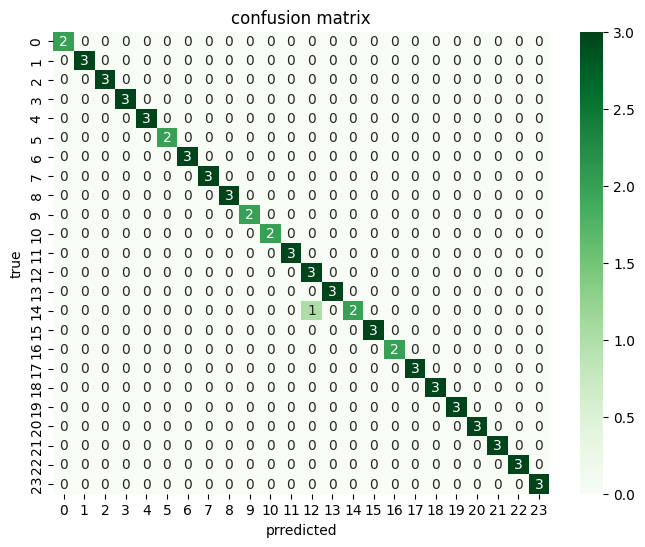


 per-user accuracy:
user
Speaker_0001    1.000000
Speaker_0002    1.000000
Speaker_0004    1.000000
Speaker_0005    1.000000
Speaker_0006    1.000000
Speaker_0007    1.000000
Speaker_0008    1.000000
Speaker_0009    1.000000
Speaker_0010    1.000000
Speaker_0011    1.000000
Speaker_0012    1.000000
Speaker_0013    1.000000
Speaker_0014    1.000000
Speaker_0015    1.000000
Speaker_0016    0.666667
Speaker_0017    1.000000
Speaker_0018    1.000000
Speaker_0019    1.000000
Speaker_0020    1.000000
Speaker_0021    1.000000
Speaker_0023    1.000000
Speaker_0024    1.000000
Speaker_0025    1.000000
Name: correct, dtype: float64

 time taken: 2758.75 seconds


In [3]:
#speechbrain

!pip install -qq speechbrain torchaudio scikit-learn matplotlib seaborn

import os, zipfile, time
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from speechbrain.pretrained import SpeakerRecognition

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
spkrec = SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    run_opts={"device": DEVICE}
)


def get_embedding(path):
    signal = spkrec.load_audio(path)
    emb = spkrec.encode_batch(signal.unsqueeze(0)).squeeze().detach().cpu().numpy()
    return emb

def build_dataset(base_dir):
    data = []
    for uid, user in enumerate(os.listdir(base_dir)):
        user_path = os.path.join(base_dir, user)
        if not os.path.isdir(user_path): continue
        wavs = sorted([f for f in os.listdir(user_path) if f.endswith(".wav")])[:14]
        for wav in wavs:
            data.append({"path": os.path.join(user_path, wav), "label": uid, "user": user})
    return pd.DataFrame(data)


DATA_DIR = "/content/50_speakers_audio_data"
df = build_dataset(DATA_DIR)

start = time.time()
embeddings, labels, user_ids = [], [], []
for _, row in tqdm(df.iterrows(), total=len(df)):
    emb = get_embedding(row["path"])
    embeddings.append(emb)
    labels.append(row["label"])
    user_ids.append(row["user"])

X = np.vstack(embeddings)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
y_pred = clf.predict(X_test)
end = time.time()

print(f"\n accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.xlabel("prredicted"), plt.ylabel("true"), plt.title("confusion matrix")
plt.show()

user_map = {i: u for i, u in enumerate(sorted(set(user_ids)))}
df_eval = pd.DataFrame({'true': y_test, 'pred': y_pred})
df_eval['user'] = df_eval['true'].map(user_map)
df_eval['correct'] = df_eval['true'] == df_eval['pred']
print("\n per-user accuracy:")
print(df_eval.groupby('user')['correct'].mean())

print(f"\n time taken: {end - start:.2f} seconds")
#requirements: 14 voice samples/user, 10 users, define a failure threshold, preprocessing steps pay attention to them (denoising, voice normalization, feature extraction)

In [1]:
!unzip /content/25_speakers_audio_data.zip

Archive:  /content/25_speakers_audio_data.zip
   creating: 50_speakers_audio_data/
  inflating: __MACOSX/._50_speakers_audio_data  
  inflating: 50_speakers_audio_data/.DS_Store  
  inflating: __MACOSX/50_speakers_audio_data/._.DS_Store  
   creating: 50_speakers_audio_data/Speaker_0006/
  inflating: __MACOSX/50_speakers_audio_data/._Speaker_0006  
   creating: 50_speakers_audio_data/Speaker_0001/
  inflating: __MACOSX/50_speakers_audio_data/._Speaker_0001  
   creating: 50_speakers_audio_data/Speaker_0008/
  inflating: __MACOSX/50_speakers_audio_data/._Speaker_0008  
   creating: 50_speakers_audio_data/Speaker_0009/
  inflating: __MACOSX/50_speakers_audio_data/._Speaker_0009  
   creating: 50_speakers_audio_data/Speaker_0007/
  inflating: __MACOSX/50_speakers_audio_data/._Speaker_0007  
   creating: 50_speakers_audio_data/Speaker_0025/
  inflating: __MACOSX/50_speakers_audio_data/._Speaker_0025  
   creating: 50_speakers_audio_data/Speaker_0014/
  inflating: __MACOSX/50_speakers_audio